# Mock population

In this notebook we generate a mock catalog of GW events

In [46]:
#IMPORT
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d
import scipy.stats as stats
import time


#PYTHON MODULES
from gw_lensing.utils.constants import *
from gw_lensing.cosmology import gwcosmo
from gw_lensing.gw_population import gwpop
from gw_lensing.utils import gwutils
from gw_lensing.utils import utils
from gw_lensing.detectors import sensitivity_curves as sc
from gw_lensing.gw_rates import rates as gwrates
from gw_lensing.optical_depth import sis_optical_depth as sistau
from gw_lensing.lens_models import sis

#Directories
import os 
PATH = os.getcwd()
catalog = 'powerlaw_peak'
dir_out = 'data_mock_catalogues/'+catalog+'/'

#PLOTS
from matplotlib.ticker import ScalarFormatter
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fontSz = 15
fontsz = 13
fontssz = 11

new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

---
## Fiducial source model

We choose our fiducial universe to have populations of BHs and NSs that are consistent with the gravitational-wave observations of LIGO--Virgo--KAGRA as of GWTC-3 (https://arxiv.org/abs/2111.03634) 

In [12]:
#Fiducial universe
from fiducial_universe_gwtc4 import *
R_0p2_bbh_fid = 29.0 #yr^-1 Gpc^-3
model_name = 'powerlaw_peak_smooth_alpha_%s_sig_%s_mu_%s_fpeak_%s_mmin_pl_%s_mmax_pl_%s_mmin_filt_%s_mmax_filt_%s_dmmin_%s_dmmax_%s '%(alpha_fid, sig_m1_fid, mu_m1_fid, f_peak_fid, mmin_pl_fid, mmax_pl_fid, mMin_filter_fid,mMax_filter_fid,dmMin_filter_fid,dmMax_filter_fid)

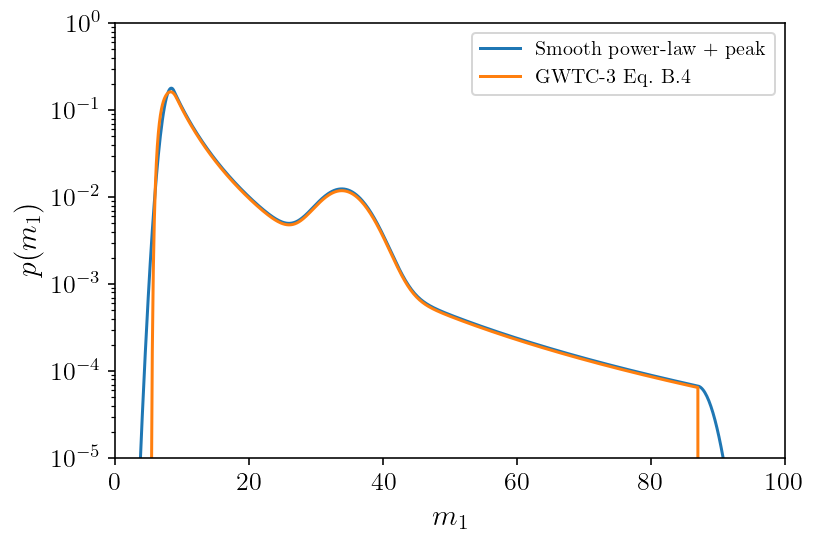

In [3]:
ms = np.linspace(0.1, 150, 1000)
pm = gwpop.powerlaw_peak_smooth(ms,mmin_pl_fid,mmax_pl_fid,alpha_fid,sig_m1_fid,mu_m1_fid,f_peak_fid,mMin_filter_fid,mMax_filter_fid,dmMin_filter_fid,dmMax_filter_fid)
pm = pm/np.trapz(pm,ms)

mmin_fid = 5.
mmax_fid = 87.
alpha_fid = -3.4
f_peak_fid = 0.04
mu_peak_fid = 34.
sig_peak_fid = 3.6
deltaM_fid = 4.8
pm_gwtc3 = gwpop.powerlaw_peak_gwtc3(ms, mmin_fid, mmax_fid, alpha_fid, sig_peak_fid, mu_peak_fid, f_peak_fid, deltaM_fid)
pm_gwtc3 = pm_gwtc3/np.trapz(pm_gwtc3,ms)

plt.plot(ms, pm,label='Smooth power-law + peak')
plt.plot(ms, pm_gwtc3,label='GWTC-3 Eq. B.4')
plt.xlabel(r'$m_1$',fontsize=fontSz)
plt.ylabel(r'$p(m_1)$',fontsize=fontSz)
plt.tick_params(axis='both', which='major', labelsize=fontsz)
plt.yscale('log')
plt.ylim(1e-5,1e0)
plt.xlim(0,100)
plt.legend()
plt.show()

We absorb the fiducial source model in a set of generic functions

In [8]:
def pz_fid(z):
    return gwpop.rate_z_norm_0p2(z,zp_fid,alpha_z_fid,beta_fid)

def pm1_bbh(mass_1):
    mMin_pl = mmin_pl_fid
    mMax_pl = mmax_pl_fid
    alpha = alpha_fid
    sig_m1 = sig_m1_fid
    mu_m1 = mu_m1_fid
    f_peak = f_peak_fid
    mMin_filter = mMin_filter_fid
    mMax_filter = mMax_filter_fid
    dmMin_filter = dmMin_filter_fid
    dmMax_filter = dmMax_filter_fid

    return gwpop.powerlaw_peak_smooth(mass_1,mMin_pl,mMax_pl,alpha,sig_m1,mu_m1,f_peak,mMin_filter,mMax_filter,dmMin_filter,dmMax_filter)

def pq_bbh(q):
    bq = bq_fid
    return utils.powerlaw(q,0.,1.,bq)

def pm2_bbh(mass_2,mass_1):
    q = mass_2/mass_1
    return pq_bbh(q)/mass_1

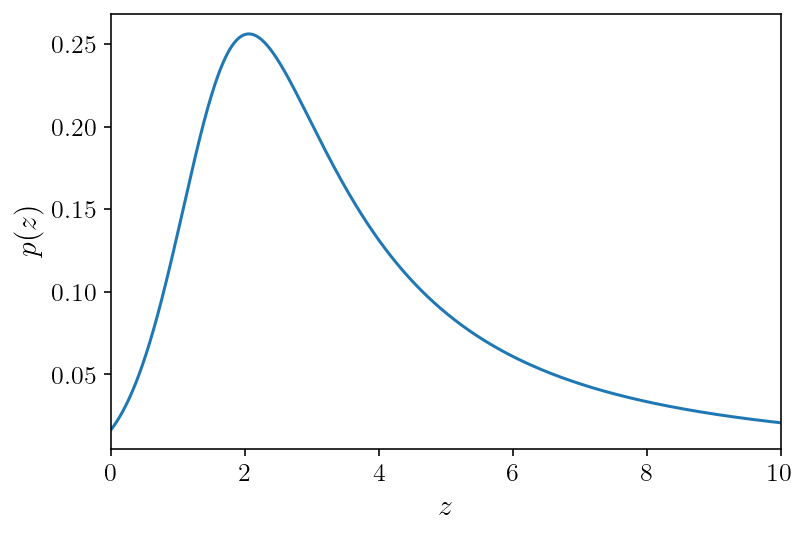

In [29]:
zs = np.linspace(0., 10., 1000)
pz = pz_fid(zs)
pz = pz/np.trapz(pz,zs)
plt.plot(zs, pz)
plt.xlabel(r'$z$',fontsize=fontSz)
plt.ylabel(r'$p(z)$',fontsize=fontSz)
plt.tick_params(axis='both', which='major', labelsize=fontsz)
plt.xlim(0,10)
plt.show()

---
## Fiducial lensed model

We choose our fiducial lens model to be a singular isothermal sphere

---
## Fiducial lensed population

We choose our fiducial lens population to be galaxies that follow a Schecter function

In [31]:
n = 8e-3 * np.power(H0_fid/100,3) #Mpc^-3
sigmaS,alpha,beta = 161, 2.32, 2.67

zs = np.linspace(0.001,30,1000)
tau_int = interp1d(zs,sistau.tau_Schechter(zs,n,sigmaS,alpha,beta),bounds_error=False,fill_value=np.nan)

In [32]:
def pz_fid_lens(z):
    return pz_fid(z) * tau_int(z)

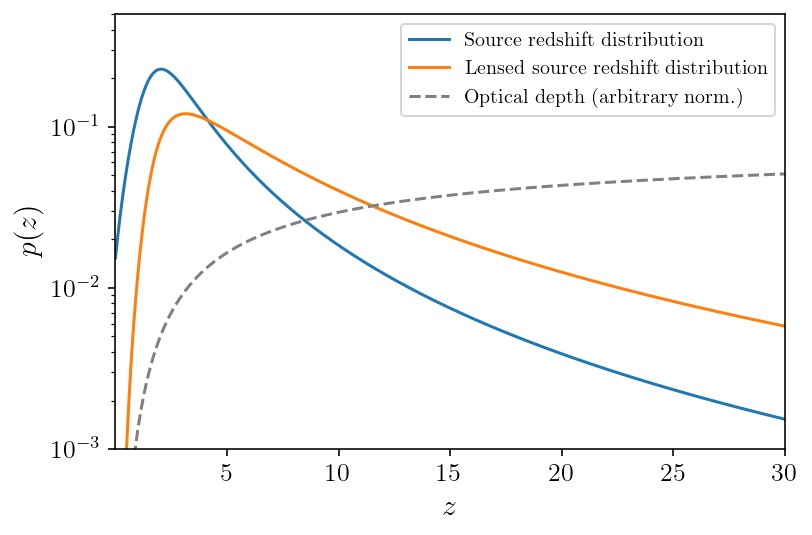

In [74]:
zs = np.linspace(0.01, 30., 1000)
pz = pz_fid(zs)
pz = pz/np.trapz(pz,zs)
pz_lens = pz_fid_lens(zs)
pz_lens = pz_lens/np.trapz(pz_lens,zs)

plt.plot(zs, pz,label='Source redshift distribution')
plt.plot(zs, pz_lens,label='Lensed source redshift distribution')
plt.plot(zs, tau_int(zs)/np.trapz(tau_int(zs),zs),'--',color='gray',label='Optical depth (arbitrary norm.)')
plt.xlabel(r'$z$',fontsize=fontSz)
plt.ylabel(r'$p(z)$',fontsize=fontSz)
plt.tick_params(axis='both', which='major', labelsize=fontsz)
plt.xlim(min(zs),max(zs))
plt.legend()
plt.yscale('log')
plt.ylim(1e-3,5e-1)
plt.show()

---
## Simulating the lensed population

In [62]:
#Mock catalogue parameters
n_detections = 1000
#n_samples = 100
n_sources = n_detections*10
#random_seed = np.random.seed(2)

In [63]:
fmin = 10.
Tobs = 1.
detector = 'A#'
based = 'ground'
snr_th = 8.0

In [67]:
def mock_lensed_population(n_sources,n_detections,H0,Om0,pz,pm1,pq,R0,zmin,zmax,mmin,mmax,snr_th,fmin,Tobs,detector,based,mu_image):
    #n_sources : number of sources to run code
    #n_samples : number of posterior samples per detection
    
    #Mock source paramters
    ww = np.linspace(0.0,1.0,1000)
    cdf_ww = 1.0-sc.pw_hl(ww)
    cdf_z, cdf_m1, cdf_q, norm_z, norm_m1, norm_q, zs_cdf, masses_cdf, qs_cdf = gwrates.compute_cdf(pz,pm1,pq,R0,H0,Om0,Tobs,zmin,zmax,mmin,mmax)
    m1z_mock_pop, m2z_mock_pop, dL_mock_pop, y_mock_pop = gwrates.mock_detector_frame_parameters(n_sources,cdf_z,cdf_m1,cdf_q,zs_cdf,masses_cdf,qs_cdf,H0,Om0)
    
    mu_mock_pop = mu_image(y_mock_pop)

    #SNR calcultion: optimal SNR -> true SNR -> observed SNR
    snr_opt_mock_pop = gwutils.vsnr(m1z_mock_pop,m2z_mock_pop,dL_mock_pop,fmin,Tobs,detector,based)*np.sqrt(abs(mu_mock_pop))
    w_mock_pop = utils.inverse_transf_sampling(cdf_ww,ww,n_sources) #random draw
    snr_true_mock_pop = snr_opt_mock_pop*w_mock_pop
    snr_obs_mock_pop = gwutils.observed_snr(snr_true_mock_pop)

    #Detected population
    detected = snr_obs_mock_pop > snr_th
    snr_opt_mock = snr_opt_mock_pop[detected]
    snr_true_mock = snr_true_mock_pop[detected]
    snr_obs_mock = snr_obs_mock_pop[detected]
    m1z_mock = m1z_mock_pop[detected]
    m2z_mock = m2z_mock_pop[detected]
    dL_mock = dL_mock_pop[detected]
    mu_mock = mu_mock_pop[detected]
    y_mock = y_mock_pop[detected]
    
    while np.size(snr_opt_mock) < n_detections:    
        cdf_z, cdf_m1, cdf_q, norm_z, norm_m1, norm_q, zs_cdf, masses_cdf, qs_cdf = gwrates.compute_cdf(pz,pm1,pq,R0,H0,Om0,Tobs,zmin,zmax,mmin,mmax)
        m1z_mock_pop, m2z_mock_pop, dL_mock_pop, y_mock_pop = gwrates.mock_detector_frame_parameters(n_sources,cdf_z,cdf_m1,cdf_q,zs_cdf,masses_cdf,qs_cdf,H0,Om0)

        mu_mock_pop = mu_image(y_mock_pop)

        snr_opt_mock_pop = gwutils.vsnr(m1z_mock_pop,m2z_mock_pop,dL_mock_pop,fmin,Tobs,detector,based)*np.sqrt(abs(mu_mock_pop))
        w_mock_pop = utils.inverse_transf_sampling(cdf_ww,ww,n_sources) #random draw
        snr_true_mock_pop = snr_opt_mock_pop*w_mock_pop
        snr_obs_mock_pop = gwutils.observed_snr(snr_true_mock_pop)
    
        detected = snr_obs_mock_pop > snr_th
        snr_opt_mock_add = snr_opt_mock_pop[detected]
        snr_true_mock_add = snr_true_mock_pop[detected]
        snr_obs_mock_add = snr_obs_mock_pop[detected]
        m1z_mock_add = m1z_mock_pop[detected]
        m2z_mock_add = m2z_mock_pop[detected]
        dL_mock_add = dL_mock_pop[detected]
        mu_mock_add = mu_mock_pop[detected]
        y_mock_add = y_mock_pop[detected]
    
        snr_opt_mock = np.append(snr_opt_mock,snr_opt_mock_add)
        snr_true_mock = np.append(snr_true_mock,snr_true_mock_add)
        snr_obs_mock = np.append(snr_obs_mock,snr_obs_mock_add)
        m1z_mock = np.append(m1z_mock,m1z_mock_add)
        m2z_mock = np.append(m2z_mock,m2z_mock_add)
        dL_mock = np.append(dL_mock,dL_mock_add)
        mu_mock = np.append(mu_mock,mu_mock_add)
        y_mock =  np.append(y_mock,y_mock_add)
    
    snr_opt_mock_det = snr_opt_mock[0:n_detections]
    snr_true_mock_det = snr_true_mock[0:n_detections]
    snr_obs_mock_det = snr_obs_mock[0:n_detections]
    m1z_mock_det = m1z_mock[0:n_detections] 
    m2z_mock_det = m2z_mock[0:n_detections]
    dL_mock_det = dL_mock[0:n_detections]
    mu_mock_det = mu_mock[0:n_detections]
    y_mock_det = y_mock[0:n_detections]
        
    return m1z_mock_det, m2z_mock_det, dL_mock_det, snr_obs_mock_det, mu_mock_det, y_mock_det

In [68]:
zmin_fid = 0.1
zmax_fid = 30.0
#Run mock population
m1z_mock_det = np.zeros(n_detections)
m2z_mock_det = np.zeros(n_detections)
dL_mock_det = np.zeros(n_detections)
snr_mock_det = np.zeros(n_detections)
mu_mock_det = np.zeros(n_detections)
y_mock_det = np.zeros(n_detections)

starttime = time.time()
m1z_mock_det,m2z_mock_det,dL_mock_det,snr_mock_det,mu_mock_det,y_mock_det = mock_lensed_population(n_sources,
                                        n_detections,
                                        H0_fid,
                                        Om0_fid,
                                        pz_fid,
                                        pm1_bbh,
                                        pq_bbh,
                                        R_0p2_bbh_fid,
                                        zmin_fid,
                                        zmax_fid,
                                        mmin_fid,
                                        mmax_fid,
                                        snr_th,
                                        fmin,
                                        Tobs,
                                        detector,
                                        based,
                                        sis.mu_plus)
print('Time taken = {} seconds'.format(time.time() - starttime))

Time taken = 84.7116448879242 seconds


## Save mock samples

In [ ]:
#Save data in a pandas data frame
###########
import pandas as pd
data = {'m1z': m1z_mock_det,
        'm2z': m2z_mock_det,
        'dL': dL_mock_det,
        'snr': snr_mock_det,
        'mu': mu_mock_det,
        'y': y_mock_det}
df = pd.DataFrame(data)
df.to_csv(f'{PATH}'+dir_out+'mock_lensed_population_'+detector+'_Ndet_%s_'% (n_detections)+model_name+'.csv', index=False)


## Plot mock population

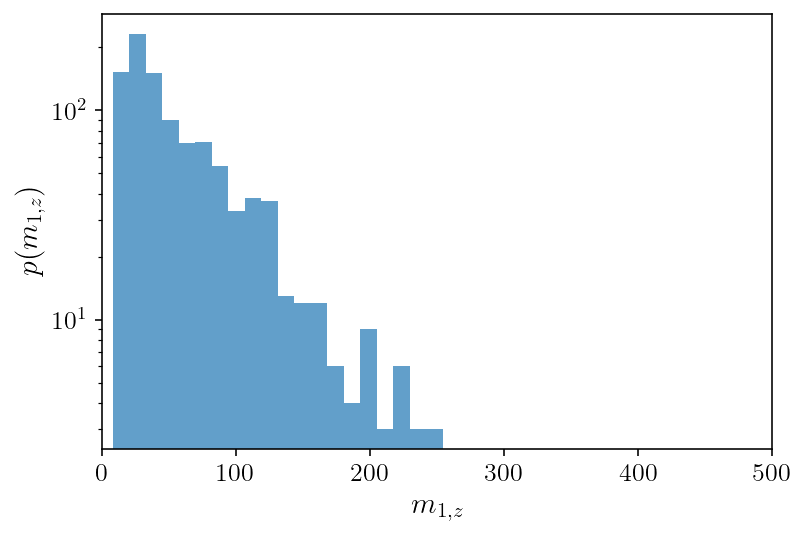

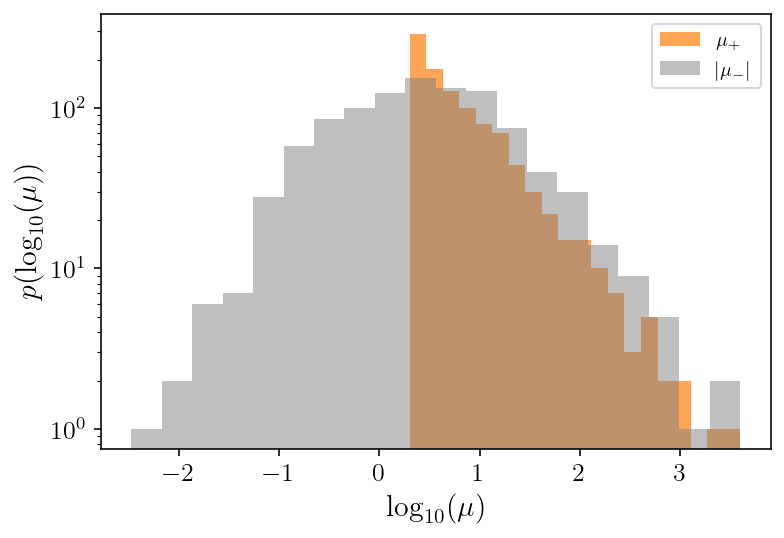

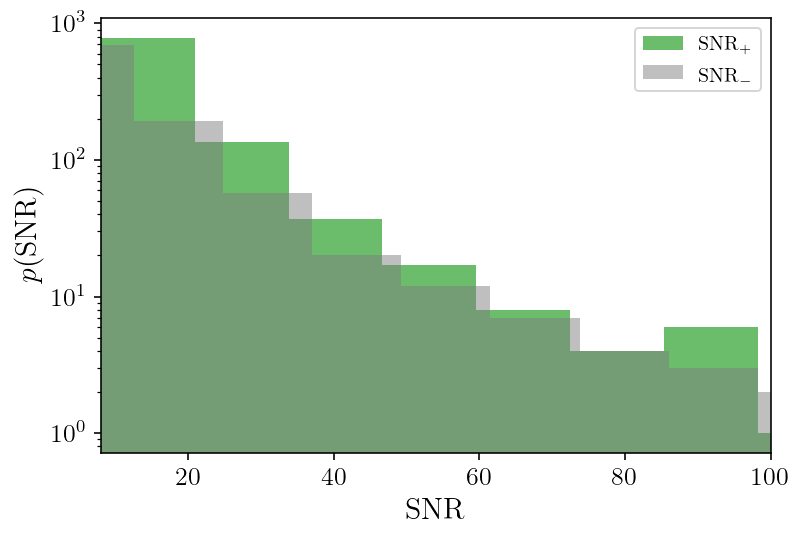

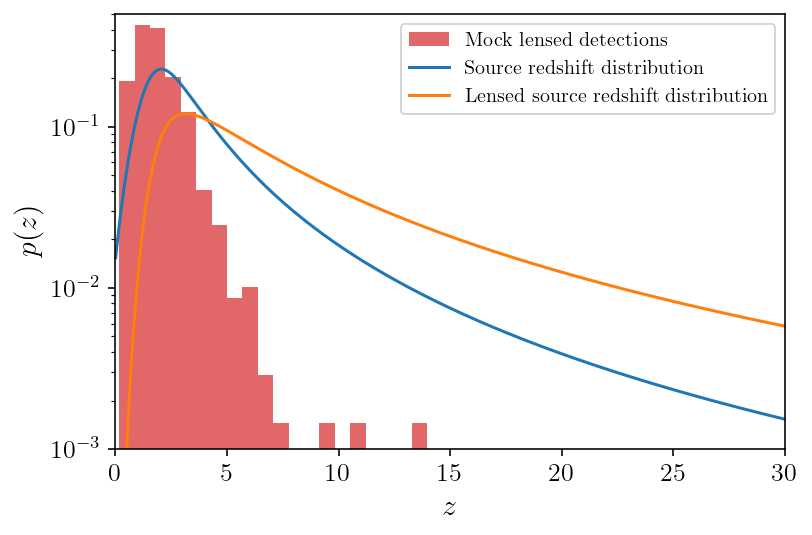

In [77]:
plt.hist(m1z_mock_det,bins=20,alpha=0.7,color=new_colors[0])
plt.xlabel(r'$m_{1,z}$',fontsize=fontSz)
plt.ylabel(r'$p(m_{1,z})$',fontsize=fontSz)
plt.tick_params(axis='both', which='major', labelsize=fontsz)
plt.yscale('log')
#plt.ylim(1e-5,1e0)
plt.xlim(0,500)
plt.show()

mu_minus_mock_det = sis.mu_minus(y_mock_det)
plt.hist(np.log10(mu_mock_det),bins=20,alpha=0.7,color=new_colors[1],label=r'$\mu_+$')
plt.hist(np.log10(abs(mu_minus_mock_det)),bins=20,alpha=0.5,color='gray',label=r'$|\mu_-|$')
plt.xlabel(r'$\log_{10}(\mu)$',fontsize=fontSz)
plt.ylabel(r'$p(\log_{10}(\mu))$',fontsize=fontSz)
plt.tick_params(axis='both', which='major', labelsize=fontsz)
plt.yscale('log')
#plt.ylim(1e-5,1e0)
#plt.xlim(1,50)
plt.legend()
plt.show()

snr_minus_mock_det = snr_mock_det * np.sqrt(abs(mu_minus_mock_det)/mu_mock_det)
plt.hist(snr_mock_det,bins=20,alpha=0.7,color=new_colors[2],label=r'SNR$_+$')
plt.hist(snr_minus_mock_det,bins=20,alpha=0.5,color='gray',label=r'SNR$_-$')
plt.xlabel(r'SNR',fontsize=fontSz)
plt.ylabel(r'$p(\mathrm{SNR})$',fontsize=fontSz)
plt.tick_params(axis='both', which='major', labelsize=fontsz)
plt.yscale('log')
#plt.ylim(1e-5,1e0)
plt.xlim(snr_th,100)
plt.legend()
plt.show()

z_mock_det = gwcosmo.z_at_dl_approx(dL_mock_det,H0_fid,Om0_fid,zmin=1e-3,zmax=50)
plt.hist(z_mock_det,bins=20,alpha=0.7,color=new_colors[3],density=True,label='Mock lensed detections')
plt.plot(zs, pz,label='Source redshift distribution')
plt.plot(zs, pz_lens,label='Lensed source redshift distribution')
plt.xlabel(r'$z$',fontsize=fontSz)
plt.ylabel(r'$p(z)$',fontsize=fontSz)
plt.tick_params(axis='both', which='major', labelsize=fontsz)
plt.yscale('log')
plt.ylim(1e-3,5e-1)
plt.xlim(0,30)
plt.legend()
plt.show()